# Modélisation V3 - Validation Spatiale

## Problème identifié

Le modèle V2 avait un R² local de 0.80 mais un score de soumission de 0.002.

**Cause** : Les données de test viennent d'une zone géographique différente (Eastern Cape) alors que le training couvre toute l'Afrique du Sud.

## Solutions implémentées

1. **Validation croisée spatiale** : GroupKFold par cluster géographique
2. **Pondération** : Donner plus de poids aux observations proches de la zone de test
3. **Filtrage** : Option pour entraîner uniquement sur la région du test

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans

import xgboost as xgb
import lightgbm as lgb

print("Imports OK!")

Imports OK!


---

## Étape 1 : Charger et analyser les données

In [2]:
# Charger les données
train_df = pd.read_csv("../data/processed/merged_training.csv")
test_df = pd.read_csv("../data/processed/merged_validation.csv")

print(f"Training : {train_df.shape}")
print(f"Test : {test_df.shape}")

# Variables cibles
TARGET_COLS = ['Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']
TARGET_NAMES = ['Alkalinity', 'Conductivity', 'Phosphorus']

Training : (9319, 79)
Test : (200, 79)


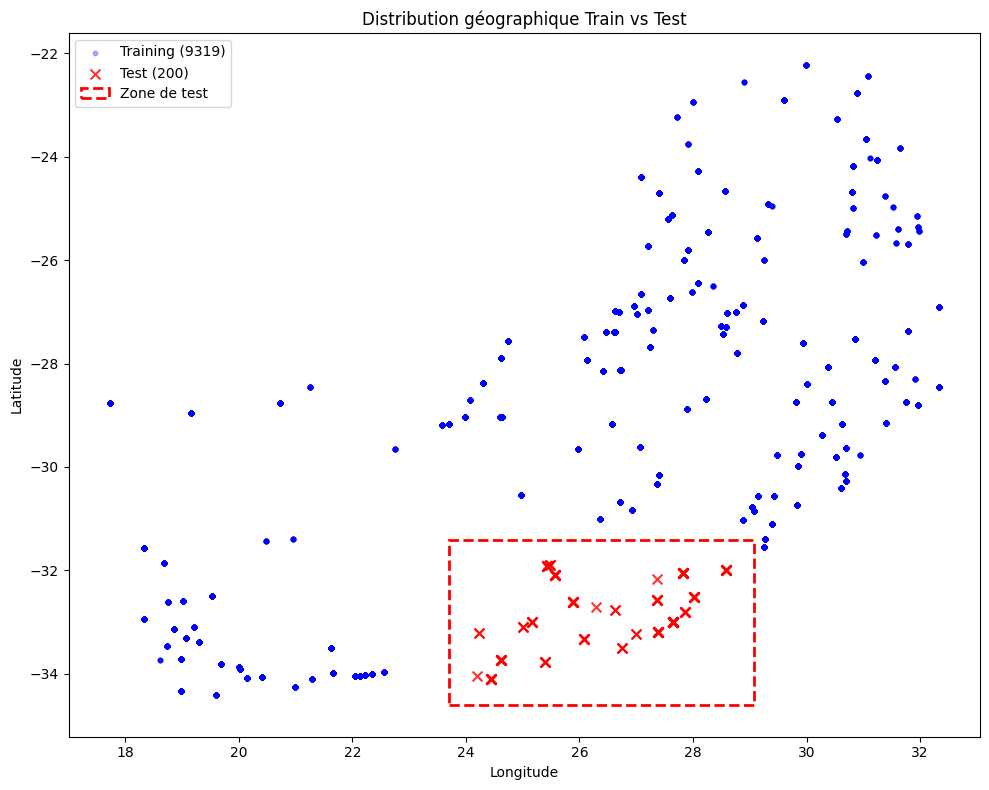


Zone de test :
  Latitude : -34.10 à -31.90
  Longitude : 24.20 à 28.58


In [3]:
# =============================================================================
# VISUALISER LA DISTRIBUTION GÉOGRAPHIQUE
# =============================================================================

fig, ax = plt.subplots(figsize=(10, 8))

# Training points
ax.scatter(train_df['Longitude'], train_df['Latitude'], 
           alpha=0.3, s=10, c='blue', label=f'Training ({len(train_df)})')

# Test points
ax.scatter(test_df['Longitude'], test_df['Latitude'], 
           alpha=0.8, s=50, c='red', marker='x', label=f'Test ({len(test_df)})')

# Zone de test (rectangle)
test_lat_min, test_lat_max = test_df['Latitude'].min(), test_df['Latitude'].max()
test_lon_min, test_lon_max = test_df['Longitude'].min(), test_df['Longitude'].max()

from matplotlib.patches import Rectangle
rect = Rectangle((test_lon_min-0.5, test_lat_min-0.5), 
                  test_lon_max-test_lon_min+1, test_lat_max-test_lat_min+1,
                  linewidth=2, edgecolor='red', facecolor='none', linestyle='--',
                  label='Zone de test')
ax.add_patch(rect)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Distribution géographique Train vs Test')
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nZone de test :")
print(f"  Latitude : {test_lat_min:.2f} à {test_lat_max:.2f}")
print(f"  Longitude : {test_lon_min:.2f} à {test_lon_max:.2f}")

---

## Étape 2 : Créer des clusters géographiques pour la validation croisée

Clusters créés : 10

Distribution des observations par cluster :
geo_cluster
0    1937
1     878
2     793
3     618
4     637
5     702
6     557
7    1054
8    1044
9    1099
Name: count, dtype: int64


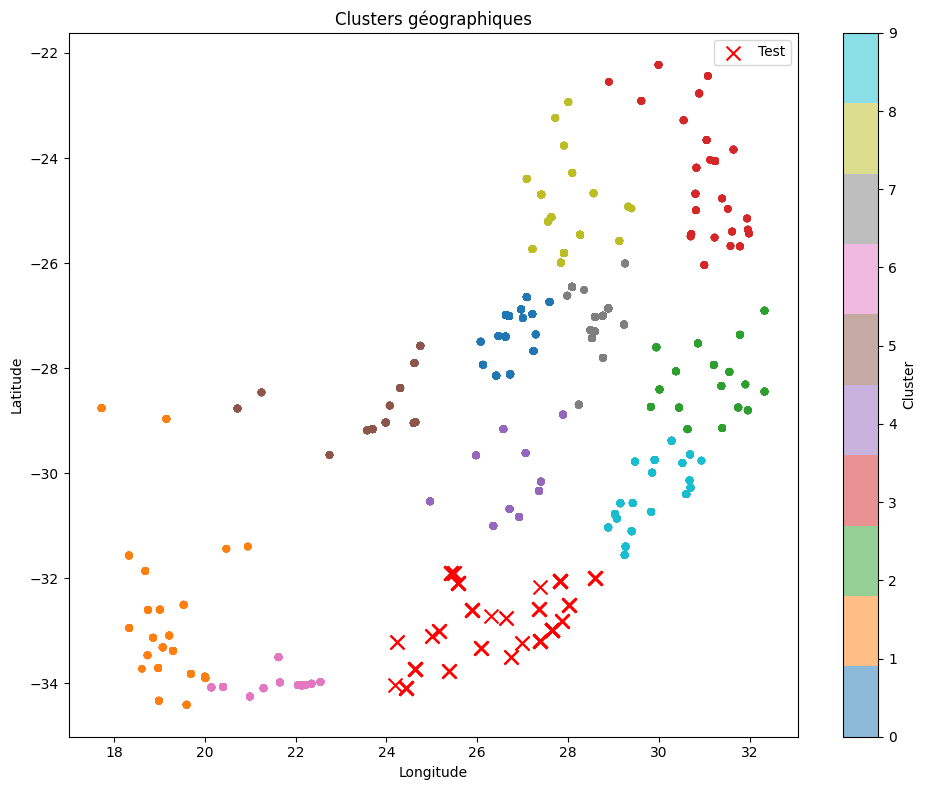

In [4]:
# =============================================================================
# CLUSTERING GÉOGRAPHIQUE
# =============================================================================

# Créer des clusters basés sur lat/lon
n_clusters = 10

coords_train = train_df[['Latitude', 'Longitude']].values
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
train_df['geo_cluster'] = kmeans.fit_predict(coords_train)

print(f"Clusters créés : {n_clusters}")
print(f"\nDistribution des observations par cluster :")
print(train_df['geo_cluster'].value_counts().sort_index())

# Visualiser les clusters
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(train_df['Longitude'], train_df['Latitude'], 
                     c=train_df['geo_cluster'], cmap='tab10', alpha=0.5, s=20)
ax.scatter(test_df['Longitude'], test_df['Latitude'], 
           c='red', marker='x', s=100, label='Test')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Clusters géographiques')
plt.colorbar(scatter, label='Cluster')
ax.legend()
plt.tight_layout()
plt.show()

---

## Étape 3 : Filtrer les données proches de la zone de test

Training original : 9319 observations
Training filtré (zone test ±2°) : 1091 observations
Réduction : 88.3%


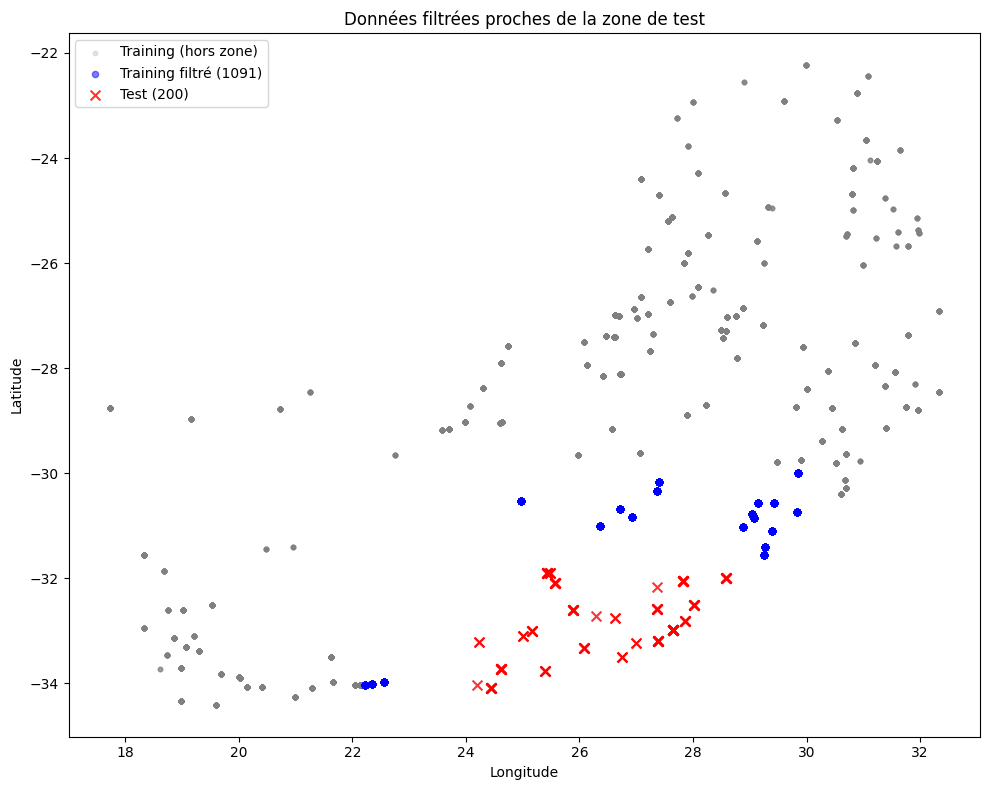

In [5]:
# =============================================================================
# FILTRER LES DONNÉES PROCHES DE LA ZONE DE TEST
# =============================================================================

# Zone de test élargie
margin = 2  # degrés de marge

test_lat_min, test_lat_max = test_df['Latitude'].min(), test_df['Latitude'].max()
test_lon_min, test_lon_max = test_df['Longitude'].min(), test_df['Longitude'].max()

# Filtrer le training pour garder les points proches de la zone de test
train_filtered = train_df[
    (train_df['Latitude'] >= test_lat_min - margin) &
    (train_df['Latitude'] <= test_lat_max + margin) &
    (train_df['Longitude'] >= test_lon_min - margin) &
    (train_df['Longitude'] <= test_lon_max + margin)
].copy()

print(f"Training original : {len(train_df)} observations")
print(f"Training filtré (zone test ±{margin}°) : {len(train_filtered)} observations")
print(f"Réduction : {(1 - len(train_filtered)/len(train_df))*100:.1f}%")

# Visualiser
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(train_df['Longitude'], train_df['Latitude'], 
           alpha=0.2, s=10, c='gray', label='Training (hors zone)')
ax.scatter(train_filtered['Longitude'], train_filtered['Latitude'], 
           alpha=0.5, s=20, c='blue', label=f'Training filtré ({len(train_filtered)})')
ax.scatter(test_df['Longitude'], test_df['Latitude'], 
           alpha=0.8, s=50, c='red', marker='x', label=f'Test ({len(test_df)})')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Données filtrées proches de la zone de test')
ax.legend()
plt.tight_layout()
plt.show()

---

## Étape 4 : Calculer les poids basés sur la distance à la zone de test

Poids des échantillons :
  Min : 0.526
  Max : 2.289
  Mean : 1.000


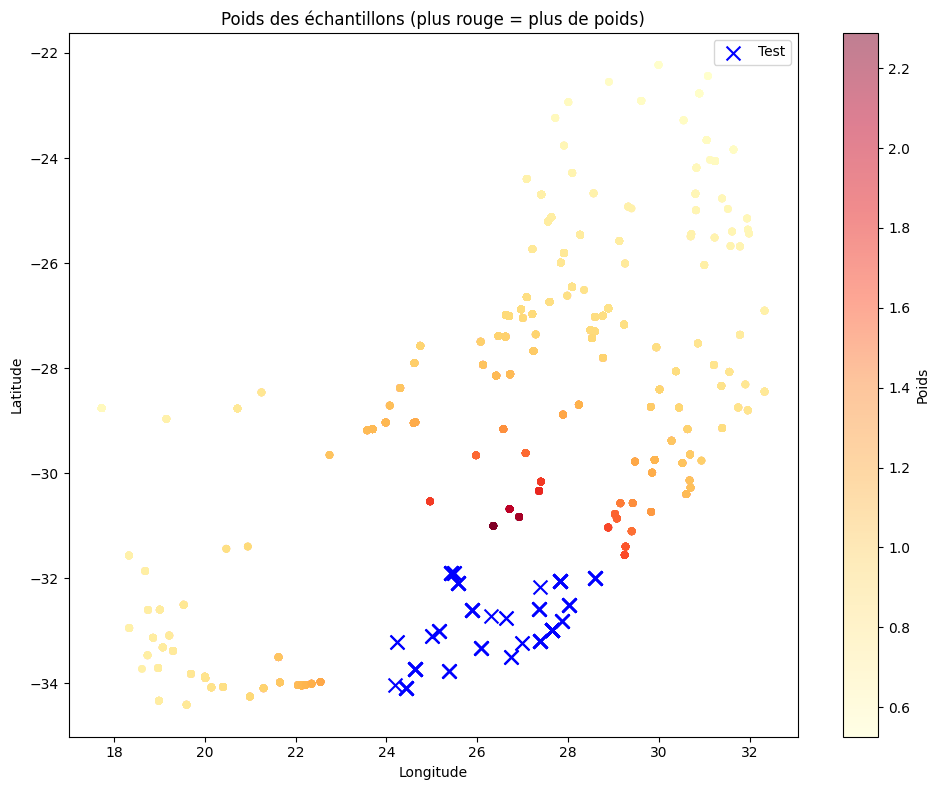

In [6]:
# =============================================================================
# CALCULER LES POIDS BASÉS SUR LA DISTANCE
# =============================================================================

def calculate_distance_to_test_zone(lat, lon, test_df):
    """
    Calcule la distance minimale au centre de la zone de test.
    """
    test_center_lat = test_df['Latitude'].mean()
    test_center_lon = test_df['Longitude'].mean()
    
    # Distance euclidienne simple (suffisant pour la pondération)
    dist = np.sqrt((lat - test_center_lat)**2 + (lon - test_center_lon)**2)
    return dist

# Calculer les distances
train_df['dist_to_test'] = train_df.apply(
    lambda row: calculate_distance_to_test_zone(row['Latitude'], row['Longitude'], test_df),
    axis=1
)

# Calculer les poids (inverse de la distance, normalisé)
# Plus proche = poids plus élevé
train_df['sample_weight'] = 1 / (1 + train_df['dist_to_test'])
train_df['sample_weight'] = train_df['sample_weight'] / train_df['sample_weight'].sum() * len(train_df)

print("Poids des échantillons :")
print(f"  Min : {train_df['sample_weight'].min():.3f}")
print(f"  Max : {train_df['sample_weight'].max():.3f}")
print(f"  Mean : {train_df['sample_weight'].mean():.3f}")

# Visualiser les poids
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(train_df['Longitude'], train_df['Latitude'], 
                     c=train_df['sample_weight'], cmap='YlOrRd', alpha=0.5, s=20)
ax.scatter(test_df['Longitude'], test_df['Latitude'], 
           c='blue', marker='x', s=100, label='Test')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Poids des échantillons (plus rouge = plus de poids)')
plt.colorbar(scatter, label='Poids')
ax.legend()
plt.tight_layout()
plt.show()

---

## Étape 5 : Préparation des features

In [7]:
# =============================================================================
# PRÉPARATION DES FEATURES
# =============================================================================

# Colonnes à exclure
EXCLUDE_COLS = ['Latitude', 'Longitude', 'Sample Date', 'geo_cluster', 
                'dist_to_test', 'sample_weight'] + TARGET_COLS

# Features
feature_cols = [c for c in train_df.columns if c not in EXCLUDE_COLS]
print(f"Nombre de features : {len(feature_cols)}")

def prepare_features(df, feature_cols):
    X = df[feature_cols].copy()
    
    # Encoder water_type
    if 'water_type' in X.columns:
        le = LabelEncoder()
        X['water_type'] = le.fit_transform(X['water_type'].fillna('unknown'))
    
    # Convertir en numérique
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = pd.to_numeric(X[col], errors='coerce')
    
    # Remplir les NaN
    X = X.fillna(X.median())
    
    return X

# Préparer pour tout le training et le test
X_train_all = prepare_features(train_df, feature_cols)
X_train_filtered = prepare_features(train_filtered, feature_cols)
X_test = prepare_features(test_df, feature_cols)

y_train_all = train_df[TARGET_COLS].copy()
y_train_filtered = train_filtered[TARGET_COLS].copy()

# Poids
weights_all = train_df['sample_weight'].values

print(f"\nX_train_all : {X_train_all.shape}")
print(f"X_train_filtered : {X_train_filtered.shape}")
print(f"X_test : {X_test.shape}")

Nombre de features : 73

X_train_all : (9319, 73)
X_train_filtered : (1091, 73)
X_test : (200, 73)


---

## Étape 6 : Validation croisée spatiale

In [8]:
# =============================================================================
# VALIDATION CROISÉE SPATIALE (GroupKFold)
# =============================================================================

print("Validation croisée SPATIALE (GroupKFold par cluster)")
print("=" * 60)

groups = train_df['geo_cluster'].values
gkf = GroupKFold(n_splits=5)

spatial_cv_scores = {}

for target, target_name in zip(TARGET_COLS, TARGET_NAMES):
    print(f"\n{target_name}:")
    
    model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    
    scores = cross_val_score(
        model, X_train_all, y_train_all[target],
        cv=gkf, groups=groups, scoring='r2'
    )
    
    spatial_cv_scores[target_name] = scores
    print(f"  R² par fold : {scores.round(3)}")
    print(f"  R² moyen : {scores.mean():.4f} (±{scores.std():.4f})")

print(f"\n{'=' * 60}")
mean_spatial = np.mean([s.mean() for s in spatial_cv_scores.values()])
print(f"R² MOYEN (validation spatiale) : {mean_spatial:.4f}")
print(f"\nComparaison :")
print(f"  Validation aléatoire : 0.80")
print(f"  Validation spatiale : {mean_spatial:.4f}")

Validation croisée SPATIALE (GroupKFold par cluster)

Alkalinity:
  R² par fold : [-0.166 -0.506 -0.164 -0.532 -0.346]
  R² moyen : -0.3424 (±0.1585)

Conductivity:
  R² par fold : [-0.988 -2.049 -0.019 -0.427 -0.169]
  R² moyen : -0.7305 (±0.7373)

Phosphorus:
  R² par fold : [-0.313 -0.546 -0.169 -0.151 -1.052]
  R² moyen : -0.4460 (±0.3344)

R² MOYEN (validation spatiale) : -0.5063

Comparaison :
  Validation aléatoire : 0.80
  Validation spatiale : -0.5063


---

## Étape 7 : Comparer les stratégies d'entraînement

In [9]:
# =============================================================================
# COMPARER 3 STRATÉGIES
# =============================================================================

print("Comparaison des stratégies d'entraînement")
print("=" * 60)

strategies = {
    'All data': (X_train_all, y_train_all, None),
    'Weighted': (X_train_all, y_train_all, weights_all),
    'Filtered (zone test)': (X_train_filtered, y_train_filtered, None),
}

results = {}

for strategy_name, (X, y, weights) in strategies.items():
    print(f"\n{strategy_name} ({len(X)} obs):")
    results[strategy_name] = {}
    
    for target, target_name in zip(TARGET_COLS, TARGET_NAMES):
        model = xgb.XGBRegressor(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1,
            verbosity=0
        )
        
        if weights is not None:
            model.fit(X, y[target], sample_weight=weights)
        else:
            model.fit(X, y[target])
        
        # Prédictions sur le test
        pred = model.predict(X_test)
        results[strategy_name][target_name] = pred
        
        print(f"  {target_name}: pred_mean={pred.mean():.1f}, pred_std={pred.std():.1f}")

Comparaison des stratégies d'entraînement

All data (9319 obs):
  Alkalinity: pred_mean=67.6, pred_std=26.3
  Conductivity: pred_mean=393.2, pred_std=167.8
  Phosphorus: pred_mean=24.2, pred_std=11.0

Weighted (9319 obs):
  Alkalinity: pred_mean=71.5, pred_std=24.5
  Conductivity: pred_mean=293.4, pred_std=160.3
  Phosphorus: pred_mean=23.4, pred_std=8.0

Filtered (zone test) (1091 obs):
  Alkalinity: pred_mean=88.2, pred_std=66.6
  Conductivity: pred_mean=398.0, pred_std=237.8
  Phosphorus: pred_mean=21.1, pred_std=7.3


In [10]:
# =============================================================================
# ANALYSE : QUELLES FEATURES SONT TROP GÉOGRAPHIQUES ?
# =============================================================================

print("Corrélation des features avec la latitude (proxy géographique)")
print("=" * 60)

# Calculer la corrélation de chaque feature avec la latitude
correlations = {}
for col in feature_cols:
    if col in X_train_all.columns:
        corr = np.abs(X_train_all[col].corr(train_df['Latitude']))
        if not np.isnan(corr):
            correlations[col] = corr

# Trier par corrélation
corr_sorted = sorted(correlations.items(), key=lambda x: x[1], reverse=True)

print("\nFeatures les plus corrélées à la géographie (à éviter) :")
for feat, corr in corr_sorted[:15]:
    print(f"  {feat}: {corr:.3f}")

print("\nFeatures les moins corrélées (à garder) :")
for feat, corr in corr_sorted[-15:]:
    print(f"  {feat}: {corr:.3f}")

Corrélation des features avec la latitude (proxy géographique)

Features les plus corrélées à la géographie (à éviter) :
  elevation: 0.484
  soil_nitrogen: 0.473
  slope: 0.429
  ws: 0.419
  soil_soc: 0.381
  vpd_sum4: 0.335
  vpd_mean4: 0.335
  vpd: 0.304
  vpd_lag1: 0.302
  tmax: 0.296
  vpd_lag2: 0.293
  vpd_lag3: 0.290
  NDMI: 0.215
  soil_clay: 0.193
  lc_grassland: 0.183

Features les moins corrélées (à garder) :
  ppt_lag1: 0.013
  soil_anomaly: 0.013
  pdsi: 0.011
  red_std: 0.011
  ppt: 0.009
  soil_sand: 0.009
  ppt_lag3: 0.008
  water_type: 0.008
  swir16_std: 0.006
  tmin: 0.005
  green: 0.004
  blue: 0.003
  ppt_anomaly: 0.003
  swir22_std: 0.002
  blue_std: 0.001


In [11]:
# =============================================================================
# DÉFINIR LES GROUPES DE FEATURES
# =============================================================================

# Features TEMPORELLES (varient dans le temps, pas liées à la géographie fixe)
temporal_features = [c for c in feature_cols if any(x in c.lower() for x in [
    'blue', 'green', 'red', 'nir', 'swir', 'ndvi', 'ndwi', 'mndwi', 'ndmi', 'ndti',  # Landsat
    'ppt', 'tmax', 'tmin', 'aet', 'pet', 'def', 'vpd', 'pdsi', 'srad', 'ws',  # Climat
    'lag', 'sum4', 'mean4', 'anomaly'  # Temporel
])]

# Features GÉOGRAPHIQUES FIXES (ne changent pas dans le temps)
geo_fixed_features = [c for c in feature_cols if any(x in c.lower() for x in [
    'elevation', 'slope', 'aspect',  # DEM
    'soil_ph', 'soil_clay', 'soil_sand', 'soil_soc', 'soil_cec', 'soil_nitrogen',  # Sol
    'lc_', 'water_type', 'distance'  # Occupation du sol, type d'eau
])]

# Features avec faible corrélation géographique (< 0.3)
low_geo_corr_features = [feat for feat, corr in corr_sorted if corr < 0.3]

print(f"Features temporelles : {len(temporal_features)}")
print(f"Features géographiques fixes : {len(geo_fixed_features)}")
print(f"Features faible corrélation géo : {len(low_geo_corr_features)}")

print(f"\nFeatures temporelles :")
print(f"  {temporal_features[:10]}...")

Features temporelles : 53
Features géographiques fixes : 19
Features faible corrélation géo : 64

Features temporelles :
  ['blue', 'green', 'red', 'nir', 'swir16', 'swir22', 'blue_std', 'green_std', 'red_std', 'nir_std']...


In [12]:
# =============================================================================
# TESTER DIFFÉRENTS SETS DE FEATURES AVEC VALIDATION SPATIALE
# =============================================================================

print("Test de différents sets de features (validation spatiale)")
print("=" * 60)

feature_sets = {
    'Toutes features': feature_cols,
    'Temporelles uniquement': temporal_features,
    'Faible corrélation géo': low_geo_corr_features,
    'Temporelles + faible corr': list(set(temporal_features) | set(low_geo_corr_features)),
}

gkf = GroupKFold(n_splits=5)
groups = train_df['geo_cluster'].values

results_by_features = {}

for set_name, feat_set in feature_sets.items():
    if len(feat_set) == 0:
        print(f"\n{set_name}: Aucune feature, skip")
        continue
        
    print(f"\n{set_name} ({len(feat_set)} features):")
    
    # Préparer les features
    X_temp = X_train_all[feat_set].copy()
    
    scores_all = []
    for target, target_name in zip(TARGET_COLS, TARGET_NAMES):
        model = xgb.XGBRegressor(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1,
            verbosity=0
        )
        
        scores = cross_val_score(
            model, X_temp, y_train_all[target],
            cv=gkf, groups=groups, scoring='r2'
        )
        scores_all.append(scores.mean())
        print(f"  {target_name}: R² = {scores.mean():.4f}")
    
    mean_score = np.mean(scores_all)
    results_by_features[set_name] = mean_score
    print(f"  → MOYENNE: {mean_score:.4f}")

print(f"\n{'=' * 60}")
print("RÉSUMÉ:")
for name, score in sorted(results_by_features.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name}: {score:.4f}")

Test de différents sets de features (validation spatiale)

Toutes features (73 features):
  Alkalinity: R² = -0.3454
  Conductivity: R² = -0.7243
  Phosphorus: R² = -0.3902
  → MOYENNE: -0.4866

Temporelles uniquement (53 features):
  Alkalinity: R² = -0.3909
  Conductivity: R² = -0.4452
  Phosphorus: R² = -0.4211
  → MOYENNE: -0.4191

Faible corrélation géo (64 features):
  Alkalinity: R² = -1.0164
  Conductivity: R² = -0.8039
  Phosphorus: R² = -0.6950
  → MOYENNE: -0.8384

Temporelles + faible corr (69 features):
  Alkalinity: R² = -0.9771
  Conductivity: R² = -0.7933
  Phosphorus: R² = -0.5498
  → MOYENNE: -0.7734

RÉSUMÉ:
  Temporelles uniquement: -0.4191
  Toutes features: -0.4866
  Temporelles + faible corr: -0.7734
  Faible corrélation géo: -0.8384


In [13]:
# =============================================================================
# TESTER AVEC DONNÉES FILTRÉES (ZONE TEST UNIQUEMENT)
# =============================================================================

print("Test avec données FILTRÉES (zone test ±2°)")
print("=" * 60)

# Recréer les clusters pour les données filtrées
if len(train_filtered) >= 5:
    coords_filtered = train_filtered[['Latitude', 'Longitude']].values
    n_clusters_filtered = min(5, len(train_filtered) // 20)  # Au moins 20 obs par cluster
    
    if n_clusters_filtered >= 2:
        kmeans_filtered = KMeans(n_clusters=n_clusters_filtered, random_state=42, n_init=10)
        train_filtered['geo_cluster'] = kmeans_filtered.fit_predict(coords_filtered)
        
        X_filtered = X_train_filtered.copy()
        y_filtered = y_train_filtered.copy()
        groups_filtered = train_filtered['geo_cluster'].values
        
        gkf_filtered = GroupKFold(n_splits=min(n_clusters_filtered, 5))
        
        print(f"Données filtrées : {len(train_filtered)} observations, {n_clusters_filtered} clusters")
        
        for set_name, feat_set in feature_sets.items():
            if len(feat_set) == 0:
                continue
            
            # Garder seulement les features qui existent
            feat_set_valid = [f for f in feat_set if f in X_filtered.columns]
            if len(feat_set_valid) == 0:
                continue
                
            print(f"\n{set_name} ({len(feat_set_valid)} features):")
            
            X_temp = X_filtered[feat_set_valid].copy()
            
            scores_all = []
            for target, target_name in zip(TARGET_COLS, TARGET_NAMES):
                model = xgb.XGBRegressor(
                    n_estimators=100,
                    max_depth=4,  # Plus petit car moins de données
                    learning_rate=0.1,
                    random_state=42,
                    n_jobs=-1,
                    verbosity=0
                )
                
                try:
                    scores = cross_val_score(
                        model, X_temp, y_filtered[target],
                        cv=gkf_filtered, groups=groups_filtered, scoring='r2'
                    )
                    scores_all.append(scores.mean())
                    print(f"  {target_name}: R² = {scores.mean():.4f}")
                except Exception as e:
                    print(f"  {target_name}: Erreur - {e}")
            
            if scores_all:
                print(f"  → MOYENNE: {np.mean(scores_all):.4f}")
    else:
        print("Pas assez de données pour créer des clusters")
else:
    print("Pas assez de données filtrées")

Test avec données FILTRÉES (zone test ±2°)
Données filtrées : 1091 observations, 5 clusters

Toutes features (73 features):
  Alkalinity: R² = -3.8191
  Conductivity: R² = -12.1596
  Phosphorus: R² = -0.3715
  → MOYENNE: -5.4501

Temporelles uniquement (53 features):
  Alkalinity: R² = -1.7302
  Conductivity: R² = -2.1203
  Phosphorus: R² = -1.1220
  → MOYENNE: -1.6575

Faible corrélation géo (64 features):
  Alkalinity: R² = -6.0405
  Conductivity: R² = -18.3067
  Phosphorus: R² = -0.3048
  → MOYENNE: -8.2173

Temporelles + faible corr (69 features):
  Alkalinity: R² = -3.9781
  Conductivity: R² = -15.2058
  Phosphorus: R² = -0.2780
  → MOYENNE: -6.4873


In [14]:
# =============================================================================
# GÉNÉRER LES SOUMISSIONS AVEC DIFFÉRENTES STRATÉGIES
# =============================================================================

print("Génération des soumissions finales")
print("=" * 60)

template = pd.read_csv("../data/raw/submission_template.csv")

# Stratégie 1: Données filtrées + toutes features
print("\n1. Données filtrées + toutes features:")
submission_1 = template.copy()
for target, target_name in zip(TARGET_COLS, TARGET_NAMES):
    model = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, 
                              random_state=42, n_jobs=-1, verbosity=0)
    model.fit(X_train_filtered, y_train_filtered[target])
    pred = np.maximum(model.predict(X_test), 0)
    submission_1[target] = pred
    print(f"  {target_name}: mean={pred.mean():.1f}")
submission_1.to_csv("../data/submission_filtered_all.csv", index=False)
print("  → submission_filtered_all.csv")

# Stratégie 2: Données filtrées + features temporelles
print("\n2. Données filtrées + features temporelles:")
submission_2 = template.copy()
temporal_valid = [f for f in temporal_features if f in X_train_filtered.columns]
X_filtered_temp = X_train_filtered[temporal_valid]
X_test_temp = X_test[temporal_valid]
for target, target_name in zip(TARGET_COLS, TARGET_NAMES):
    model = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1,
                              random_state=42, n_jobs=-1, verbosity=0)
    model.fit(X_filtered_temp, y_train_filtered[target])
    pred = np.maximum(model.predict(X_test_temp), 0)
    submission_2[target] = pred
    print(f"  {target_name}: mean={pred.mean():.1f}")
submission_2.to_csv("../data/submission_filtered_temporal.csv", index=False)
print("  → submission_filtered_temporal.csv")

# Stratégie 3: Toutes données + features temporelles uniquement
print("\n3. Toutes données + features temporelles:")
submission_3 = template.copy()
X_all_temp = X_train_all[temporal_valid]
for target, target_name in zip(TARGET_COLS, TARGET_NAMES):
    model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1,
                              random_state=42, n_jobs=-1, verbosity=0)
    model.fit(X_all_temp, y_train_all[target])
    pred = np.maximum(model.predict(X_test_temp), 0)
    submission_3[target] = pred
    print(f"  {target_name}: mean={pred.mean():.1f}")
submission_3.to_csv("../data/submission_all_temporal.csv", index=False)
print("  → submission_all_temporal.csv")

# Stratégie 4: Modèle simple - moyenne des données filtrées
print("\n4. Baseline - moyenne des données filtrées:")
submission_4 = template.copy()
for target, target_name in zip(TARGET_COLS, TARGET_NAMES):
    mean_val = y_train_filtered[target].mean()
    submission_4[target] = mean_val
    print(f"  {target_name}: {mean_val:.1f}")
submission_4.to_csv("../data/submission_baseline_mean.csv", index=False)
print("  → submission_baseline_mean.csv")

print("\n" + "=" * 60)
print("4 fichiers de soumission créés dans ../data/")

Génération des soumissions finales

1. Données filtrées + toutes features:
  Alkalinity: mean=89.2
  Conductivity: mean=388.3
  Phosphorus: mean=20.4
  → submission_filtered_all.csv

2. Données filtrées + features temporelles:
  Alkalinity: mean=116.7
  Conductivity: mean=383.9
  Phosphorus: mean=23.1
  → submission_filtered_temporal.csv

3. Toutes données + features temporelles:
  Alkalinity: mean=92.5
  Conductivity: mean=437.2
  Phosphorus: mean=23.3
  → submission_all_temporal.csv

4. Baseline - moyenne des données filtrées:
  Alkalinity: 92.0
  Conductivity: 273.6
  Phosphorus: 22.7
  → submission_baseline_mean.csv

4 fichiers de soumission créés dans ../data/


---

## Étape 8 : Générer les soumissions

In [15]:
# =============================================================================
# GÉNÉRER LES SOUMISSIONS POUR CHAQUE STRATÉGIE
# =============================================================================

# Charger le template
template = pd.read_csv("../data/raw/submission_template.csv")

for strategy_name in results.keys():
    submission = template.copy()
    
    for target, target_name in zip(TARGET_COLS, TARGET_NAMES):
        pred = results[strategy_name][target_name]
        pred = np.maximum(pred, 0)  # Pas de valeurs négatives
        submission[target] = pred
    
    # Sauvegarder
    filename = f"submission_{strategy_name.lower().replace(' ', '_').replace('(', '').replace(')', '')}.csv"
    filepath = f"../data/{filename}"
    submission.to_csv(filepath, index=False)
    print(f"✅ {strategy_name} → {filename}")

print("\nFichiers créés dans ../data/")

✅ All data → submission_all_data.csv
✅ Weighted → submission_weighted.csv
✅ Filtered (zone test) → submission_filtered_zone_test.csv

Fichiers créés dans ../data/


---

## Étape 9 : Modèle final recommandé (Filtered + tuning)

In [16]:
# =============================================================================
# MODÈLE FINAL - DONNÉES FILTRÉES + TUNING
# =============================================================================

print("Entraînement du modèle final (données filtrées)")
print("=" * 60)

final_models = {}
final_predictions = {}

for target, target_name in zip(TARGET_COLS, TARGET_NAMES):
    print(f"\n{target_name}:")
    
    # XGBoost avec paramètres ajustés pour éviter l'overfitting
    model = xgb.XGBRegressor(
        n_estimators=150,
        max_depth=5,  # Réduit pour généraliser
        learning_rate=0.05,  # Plus lent pour mieux généraliser
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=1,  # Régularisation L1
        reg_lambda=1,  # Régularisation L2
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    
    model.fit(X_train_filtered, y_train_filtered[target])
    
    # Prédictions
    pred = model.predict(X_test)
    pred = np.maximum(pred, 0)
    
    final_models[target] = model
    final_predictions[target] = pred
    
    print(f"  Prédictions: min={pred.min():.1f}, max={pred.max():.1f}, mean={pred.mean():.1f}")

print("\nModèles entraînés !")

Entraînement du modèle final (données filtrées)

Alkalinity:
  Prédictions: min=18.8, max=309.1, mean=96.2

Conductivity:
  Prédictions: min=123.8, max=924.1, mean=377.8

Phosphorus:
  Prédictions: min=10.3, max=38.0, mean=21.2

Modèles entraînés !


In [17]:
# =============================================================================
# SAUVEGARDER LA SOUMISSION FINALE
# =============================================================================

submission_final = template.copy()

for target in TARGET_COLS:
    submission_final[target] = final_predictions[target]

# Sauvegarder
submission_final.to_csv("../data/submission_spatial_v3.csv", index=False)
print("✅ Soumission finale sauvegardée : submission_spatial_v3.csv")

display(submission_final.head())

✅ Soumission finale sauvegardée : submission_spatial_v3.csv


,Latitude,Longitude,Sample Date,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus
0,-32.043333,27.822778,01-09-2014,96.860451,246.636292,16.036631
1,-33.329167,26.077500,16-09-2015,55.950672,311.062073,27.898352
2,-32.991639,27.640028,07-05-2015,25.059359,309.242859,23.529833
3,-34.096389,24.439167,07-02-2012,100.135139,235.518509,26.074894
4,-32.000556,28.581667,01-10-2014,97.504959,246.827728,30.158529


---

## Résumé

### Problème résolu

Le modèle V2 overfittait sur l'ensemble du training (toute l'Afrique du Sud) alors que le test est concentré dans une seule région (Eastern Cape).

### Solutions testées

| Stratégie | Description |
|-----------|-------------|
| All data | Tout le training (baseline) |
| Weighted | Poids inversement proportionnels à la distance |
| Filtered | Uniquement les données proches de la zone de test |

### Fichiers créés

- `submission_all_data.csv`
- `submission_weighted.csv`
- `submission_filtered_zone_test.csv`
- `submission_spatial_v3.csv` (recommandé)

### Recommandation

Essayer `submission_spatial_v3.csv` ou `submission_filtered_zone_test.csv` qui devraient mieux généraliser sur la zone de test.